In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf  
yf.pdr_override()

In [16]:
now = datetime.now()

before = now - relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
befor_day = before.strftime("%Y-%m-%d")
print(f"end  : {now_day}")
print(f"start: {befor_day}")

samsung_stock = pdr.get_data_yahoo( "005930.KS", start=befor_day, end=now_day)
print(samsung_stock)

end  : 2022-11-13
start: 2012-11-13
[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2012-11-13  26940.0  26980.0  26520.0  26980.0  21587.324219   7325850
2012-11-14  27140.0  27140.0  26920.0  27100.0  21683.341797  10436000
2012-11-15  26700.0  26760.0  26520.0  26620.0  21299.279297   9959100
2012-11-16  26440.0  26520.0  26020.0  26140.0  20915.228516  12172550
2012-11-19  26300.0  26840.0  26260.0  26640.0  21315.279297  10137500
...             ...      ...      ...      ...           ...       ...
2022-11-07  59700.0  60300.0  59400.0  60200.0  60200.000000  12437246
2022-11-08  60500.0  61900.0  60500.0  61800.0  61800.000000  18273898
2022-11-09  62000.0  62200.0  61300.0  62000.0  62000.000000  14045592
2022-11-10  61400.0  61500.0  60400.0  60400.0  60400.000000  21087633
2022-11-11  63100.0  63200.0  62300.0  6290

In [17]:
close_prices = samsung_stock['Close'].values
print(close_prices)

windown_size = 30

result_list = []
for i in range(len(close_prices) - (windown_size + 1)):
    result_list.append(close_prices[i: i + (windown_size + 1)])

normal_data = []
for window in result_list:
    window_list = [((float(p) / float(window[0])) - 1) for p in window]
    normal_data.append(window_list)

result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])

[26980. 27100. 26620. ... 62000. 60400. 62900.]
2425 31


In [18]:
row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result_list[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result_list[row:, -1]

x_train.shape, x_test.shape

((2182, 30, 1), (243, 30, 1))

In [19]:
model = Sequential()
model.add(LSTM(windown_size, return_sequences=True, input_shape=(windown_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 30)            3840      
                                                                 
 lstm_5 (LSTM)               (None, 64)                24320     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=10)

model.save(r'C:\Users\seoyc\OneDrive\바탕 화면\python_machineLearning_ex\39. 삼성전자의 주식 예측하기\samsung.h5')

Epoch 1/10
219/219 [==============================] - 5s 25ms/step - loss: 3.0885e-04 - val_loss: 3.3602e-04
Epoch 2/10
219/219 [==============================] - 8s 36ms/step - loss: 3.1026e-04 - val_loss: 2.7238e-04
Epoch 3/10
219/219 [==============================] - 6s 28ms/step - loss: 2.9615e-04 - val_loss: 2.1725e-04
Epoch 4/10
219/219 [==============================] - 6s 26ms/step - loss: 3.0788e-04 - val_loss: 2.7057e-04
Epoch 5/10
219/219 [==============================] - 7s 30ms/step - loss: 3.0106e-04 - val_loss: 2.0606e-04
Epoch 6/10
219/219 [==============================] - 6s 29ms/step - loss: 3.0375e-04 - val_loss: 2.7967e-04
Epoch 7/10
219/219 [==============================] - 6s 27ms/step - loss: 2.9977e-04 - val_loss: 2.0132e-04
Epoch 8/10
219/219 [==============================] - 6s 25ms/step - loss: 2.9963e-04 - val_loss: 2.8740e-04
Epoch 9/10
219/219 [==============================] - 5s 24ms/step - loss: 2.9906e-04 - val_loss: 1.9639e-04
Epoch 10/10
219/219

8/8 [==============================] - 0s 5ms/step


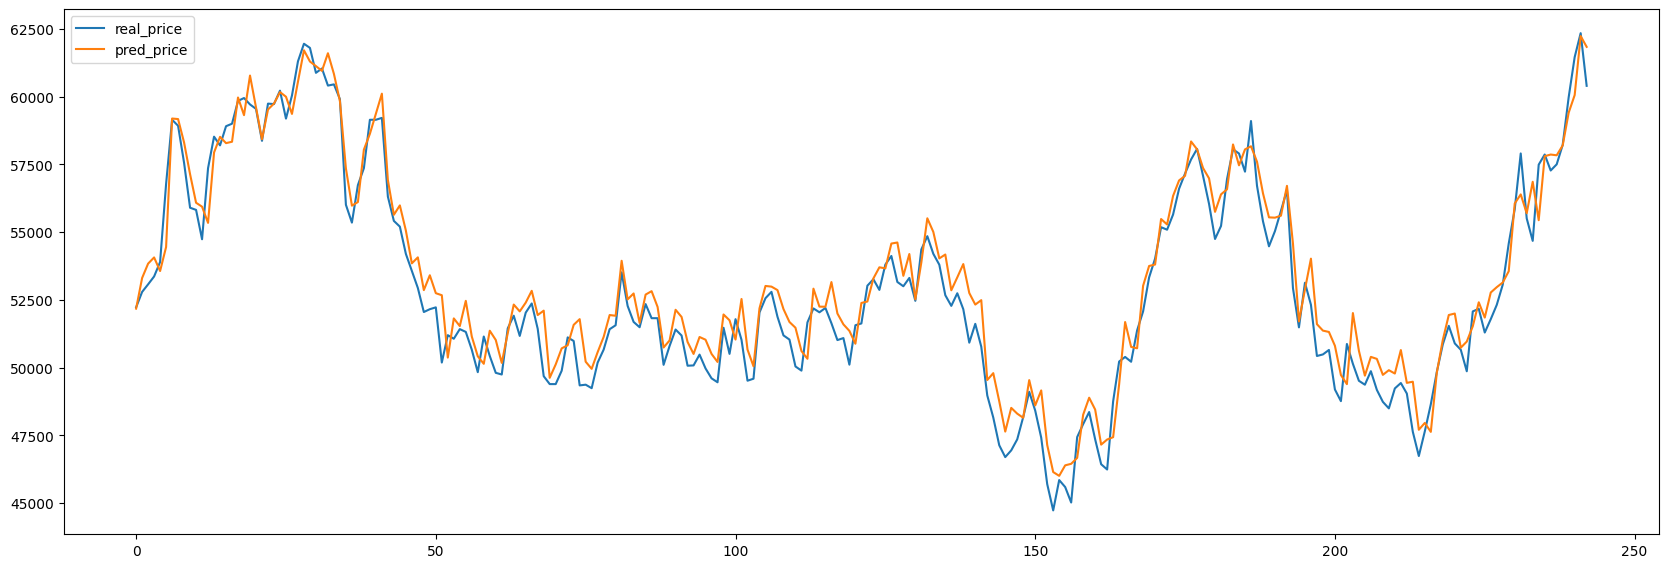

In [23]:
pred = model.predict(x_test)

pred_price = []
for i in pred:
    pred_price.append( (i + 1) * window[0] )
    
real_price = []
for i in y_test:
    real_price.append( (i + 1) * window[0] )

fig = plt.figure(facecolor='white', figsize=(70, 15))
ax = fig.add_subplot(234)
ax.plot(real_price, label='real_price')
ax.plot(pred_price, label='pred_price')
ax.legend()
plt.show()